In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
print(os.listdir("../input"))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['histopathologic-cancer-detection']


**Libraries**

In general i like to load libraries "on the go" as this makes the code more understandable, therefore i will only load the most used libraries here

In [40]:
#import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import layers


# Import the data


In [41]:
train_labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

# Initial Data Inspection

The training data is splitted into the pictures and the labels. The can be joined by the unique picture ID which is also provided in the train_label file.

Lets have a look at the labels and the IDs

In [42]:
print("Lets look at the first rows: ")
print(train_labels.head())


Lets look at the first rows: 
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


# Importing the files

Since the files are very large and the pictures and labels need to be joined together i decided to process them in random batches. I specify the batch size and the amount of batches and then import those pictures and join them with the respective label.

First i define a function that imports the files, joines them by ID and splits them into train and test files.

In [43]:
from os import listdir
from os.path import isfile, join
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random


def getfiles(path, file_list):
    files = pd.DataFrame(columns = ["id", "image_data"])

    for file in range(0,len(file_list)):  
        current_file_path = join(path, file_list[file])
    
        if isfile(current_file_path):
            img = plt.imread(current_file_path)

            if file % 3 == 0:
                img = np.rot90(img)
            elif file % 5 == 0:
                img = np.flipud(img)
            elif file % 7 == 0:
                img = np.fliplr(img)
            
            new_file_path = current_file_path.replace(".tif", "")
            new_file_path = new_file_path[new_file_path.rfind("/")+1:]
            files.loc[len(files)] = [new_file_path, img]

    complete_files = pd.merge(files,train_labels, how = "left",on = "id" ).drop(columns = ["id"])
    complete_files = complete_files.to_numpy()
    complete_files[:,0] = complete_files[:,0] / 255

    X_train, X_test, y_train, y_test = train_test_split(np.stack(complete_files[:,0], axis = 0), 
                                                        complete_files[:,1], test_size=0.2, random_state=4790)
    
    return list(X_train), list(X_test), list(y_train.astype("float32")), list(y_test.astype("float32") )

I will now iterate over the getfiles function and load the data into my working memory. 

In [44]:
mypath = "/kaggle/input/histopathologic-cancer-detection/train"
file_list = listdir(mypath)
random.shuffle(file_list)

num_batches = 2
batch_size = 1000
batch_start = 0

X_train = list()
X_test = list()
y_train = list()
y_test = list()

for i in range(num_batches):
    print("Current batch number is: ", i+1)
    current_files = file_list[batch_start:batch_size+batch_start]
    A, B, C, D = getfiles(mypath, current_files)
    X_train.append(A)
    X_test.append(B)
    y_train.append(C)
    y_test.append(D)
    batch_start += batch_size

Current batch number is:  1
Current batch number is:  2


Lastly i need to do some reshaping of the data in order to make it ready for inputting it into keras. 
The first dimension is the amount of files in the data and the other dimensions specify the picture size which is 96x96x3

In [45]:
X_train = np.asarray(X_train).reshape((np.asarray(X_train).shape[0] * np.asarray(X_train).shape[1],96,96,3))
y_train = np.asarray(y_train).reshape((np.asarray(y_train).shape[0] * np.asarray(y_train).shape[1], ))
X_test = np.asarray(X_test ).reshape((np.asarray(X_test ).shape[0] * np.asarray(X_test ).shape[1],96,96,3))
y_test = np.asarray(y_test ).reshape((np.asarray(y_test ).shape[0] * np.asarray(y_test ).shape[1], ))

Lets check if our reshaping did output the correct file shape:

In [46]:
print(X_train.shape)

(1600, 96, 96, 3)


In [47]:
print("Length of the train file is: ", np.asarray(y_train).shape)

Length of the train file is:  (1600,)


# Data Inspection and Cleaning

Lets first see if we have any NA's in our file

In [48]:
print("Number of NaNs in the train label array is: ", len(y_train[np.isnan(y_train) == True]))
print("Number of NaNs in the train data array is: ", len(X_train[np.isnan(X_train) == True]))
print("Number of NaNs in the test label array is: ", len(y_test[np.isnan(y_test) == True]))
print("Number of NaNs in the test data array is: ", len(X_test[np.isnan(X_test) == True]))

Number of NaNs in the train label array is:  0
Number of NaNs in the train data array is:  0
Number of NaNs in the test label array is:  0
Number of NaNs in the test data array is:  0


Lets have a look at a couple of the images:

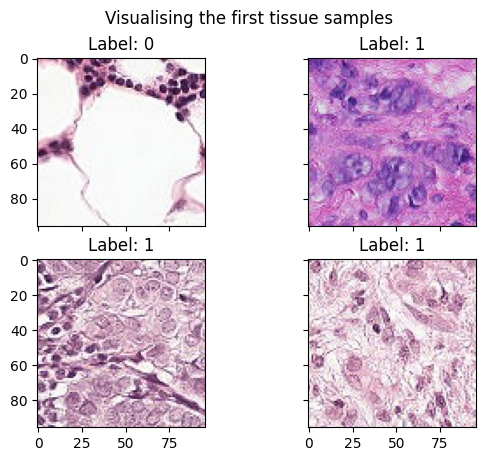

In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Visualising the first tissue samples')
ax1.imshow(X_train[0])
ax1.set_title('Label: ' + str(int(y_train[0])))
ax2.imshow(X_train[1])
ax2.set_title('Label: ' + str(int(y_train[1])))
ax3.imshow(X_train[2])
ax3.set_title('Label: ' + str(int(y_train[2])))
ax4.imshow(X_train[3])
ax4.set_title('Label: ' + str(int(y_train[3])))

for ax in fig.get_axes():
    ax.label_outer()

# Train the model

Lets train our model with keras. I tested several versions of the model including adding Dropout layers, Pooling layers and adding different types if dense layers. This simple model was most successfull in prediction cancerous tissue. 

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, Dropout

model = Sequential()

model.add(Conv2D(filters = 20, kernel_size = 2, padding = "same", input_shape=(X_train[0].shape), activation = "relu"))
model.add(Conv2D(filters = 10, kernel_size = 2, padding = "same", activation = "relu"))


model.add(Flatten())
#model.add(Dense(256, activation = "relu"))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 96, 96, 20)          │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 96, 96, 10)          │             810 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 92160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │          92,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,231 (364.18 KB)

 Trainable params: 93,231 (364.18 KB)

 Non-trainable params: 0 (0.00 B)

None


In [53]:
import keras
opt = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(
  optimizer=opt,
  loss='binary_crossentropy',
  metrics=['AUC'], # AUC ?
)

In [54]:
from tensorflow.keras.utils import to_categorical

history = model.fit(
  X_train,
  y_train,
  epochs=50,
  verbose = 0,
  shuffle = True,
  validation_data=(X_test,y_test))

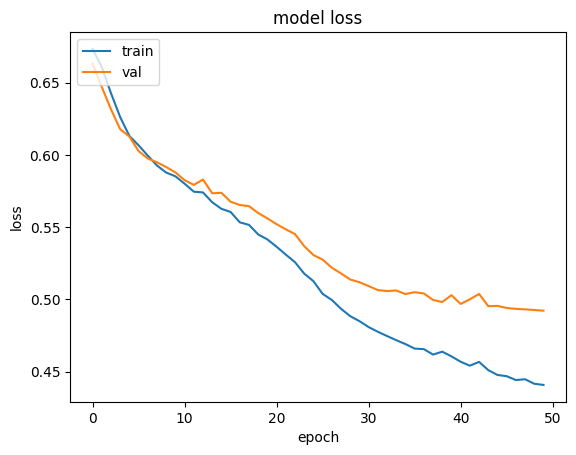

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

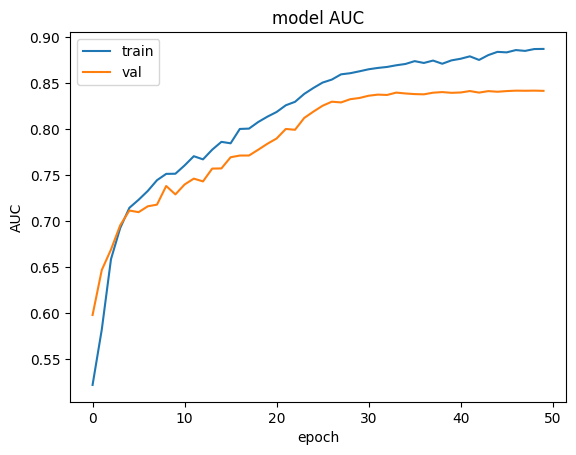

In [56]:
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predict on new data

Lets import the test dataset and let our model predict on the images. 

In [57]:
import cv2
from glob import glob 

base_test_dir = "/kaggle/input/histopathologic-cancer-detection/" + 'test/' 
test_files = glob(os.path.join(base_test_dir,'*.tif')) 
submission = pd.DataFrame() 
# predict batch of 10000 image
file_batch = 10000 
max_id =  len(test_files)
for idx in range(0, max_id, file_batch): 
    
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) #add the filenames to the dataframe

    test_df['id'] = test_df.path.map(lambda x: x.split('/')[5].split(".")[0]) #add the ids to the dataframe

    test_df['image'] = test_df['path'].map(cv2.imread) 
    K_test = np.stack(test_df["image"].values) 
    
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    #print(predictions)
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() #display first lines

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1.0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1.0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1.0


In [58]:
print("Minimum predicted probability: ", submission.label.min(axis=0))
print("Maximum predicted probability: ", submission.label.max(axis=0))

Minimum predicted probability:  0.0
Maximum predicted probability:  1.0


# Submission File

Recode probabilities to binary values at cutof 0.5

In [59]:
submission.label = np.where(submission.label > 0.5, 1,0)

In [60]:
print("Amount of images labelled as cancerous: ", len(submission[submission.label > 0]))

Amount of images labelled as cancerous:  2803


In [61]:
print("Amount of images labelled as non cancerous: ", len(submission[submission.label == 0]))

Amount of images labelled as non cancerous:  3197


In [62]:
submission.to_csv("submission.csv", index = False, header = True) 